## **_micrograduate_**: from backprop to GPT!

### 6. **makemore** (part 5): building a **WaveNet**

#### **intro**

Hi everyone! Today we are continuing our implementation of makemore, our favorite character-level language model. Now, you'll notice that the background behind me is different. Now, over the last few lectures, we've built up to this architecture that is a multi-layer perceptron character-level language model. So we see that it receives three previous characters and tries to predict the fourth character in a sequence using a very simple **mlp** using one hidden layer of neurons with `tanh` nonlinearities:

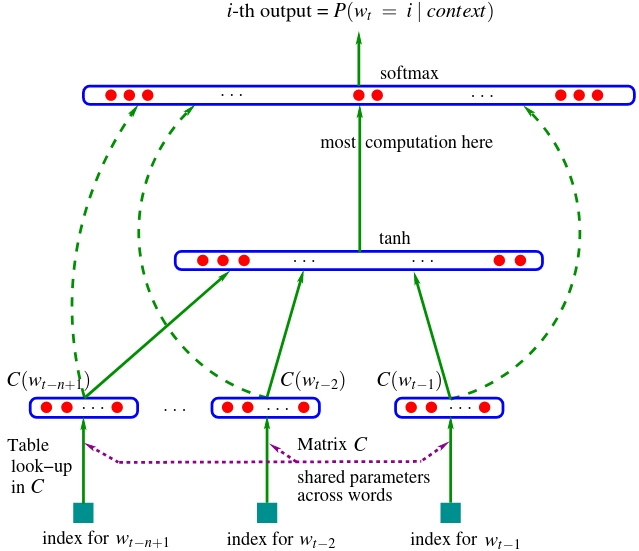

In [1]:
from IPython.display import Image, display
display(Image(filename='bengio2003nn.jpeg'))

So what we'd like to do now in this lecture is to complexify this architecture. In particular, we would like to take more characters in a sequence as an input, not just three. And in addition to that, we don't just want to feed them all into a single hidden layer because that squashes too much information too quickly. Instead, we would like to make a deeper model that progressively fuses this information to make its guess about the next character in a sequence. And so we'll see that as we make this architecture more complex, we'll be able to make a more complex model that progressively fuses this information to make it more complex. We're actually going to arrive at something that looks very much like a **WaveNet**. So [**WaveNet** is this paper published by DeepMind in 2016](https://arxiv.org/abs/1609.03499). And it is also a language model, basically, but it tries to predict audio sequences instead of character-level sequences or word-level sequences:

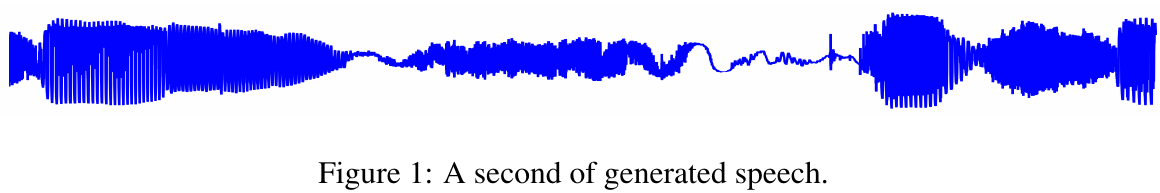

In [2]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig1.png'))

But fundamentally, the modeling setup is identical. It is an autoregressive model and it tries to predict the next character in a sequence: 

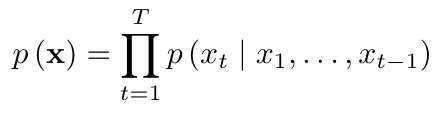

In [3]:
from IPython.display import Image, display
display(Image(filename='wavenet_eq1.png'))

And the architecture actually takes this interesting hierarchical sort of approach to predicting the next character in a sequence with this tree-like structure:

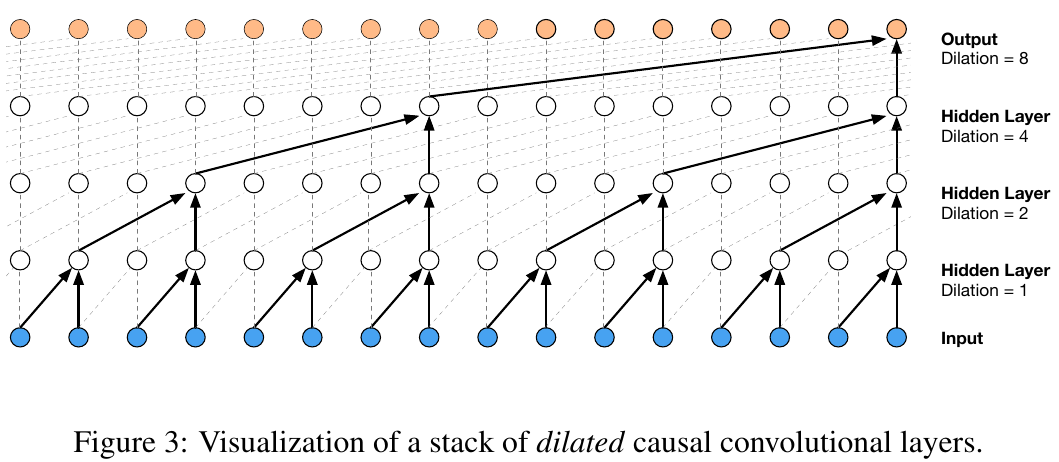

In [4]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig3.png'))

And this is the architecture:

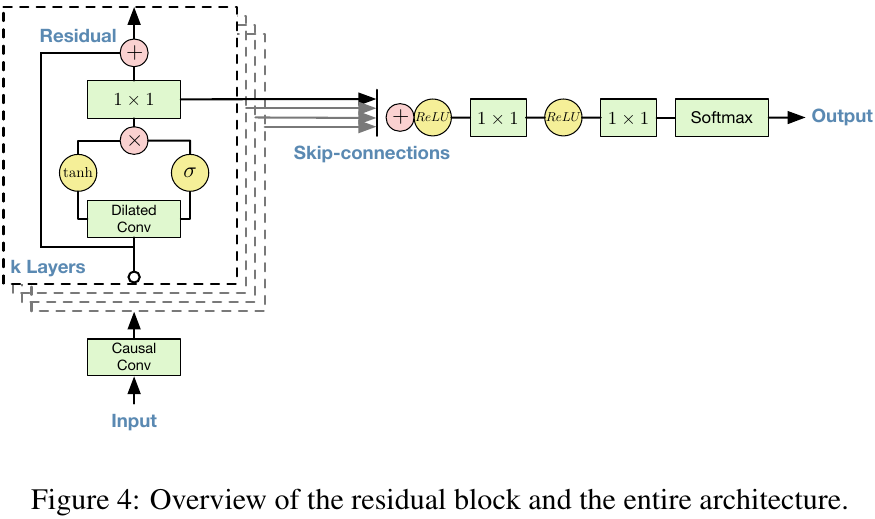

In [5]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig4.png'))

And we're going to implement it in the course of this video. So let's get started!

#### **starter code walkthrough**

The starter code for this part is very similar to where we ended up in makemore part 3. So very briefly, we are doing imports:

In [6]:
import random
random.seed(42)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib ipympl
SEED = 2147483647

We are reading our data set of words:

In [7]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


And we are processing the dataset of words into lots and lots of individual examples:

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
ctoi = {s:i+1 for i,s in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:s for s,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
def build_dataset(words, block_size): 
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ctoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # crop and append
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

In [10]:
def build_all_datasets(block_size):
    random.shuffle(words)
    n1 = int(0.8*len(words))
    n2 = int(0.9*len(words))
    xtrain_dataset = build_dataset(words[:n1], block_size)  # 80%
    xval_dataset = build_dataset(words[n1:n2], block_size)  # 10%
    xtest_dataset  = build_dataset(words[n2:], block_size)  # 10%
    return xtrain_dataset, xval_dataset, xtest_dataset

In [11]:
def print_next_character(xtrain, ytrain):
    for x, y in zip(xtrain, ytrain):
        print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

Specifically many examples of...

In [12]:
block_size = 3  # context length: how many characters do we take to predict the next one?
(xtrain, ytrain), (xval, yval), (xtest, ytest) = build_all_datasets(block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


... `block_size=3` characters and we are trying to predict the fourth one:

In [13]:
print_next_character(xtrain[:20], ytrain[:20])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


Basically we are breaking down each of these word into little problems of "given three characters, predict the fourth one". So this is our data set and this is what we're trying to get the **nn** to do. Now in part 3 we started to develop our code around these following layer modules that are for example a `class Linear`. We're doing this because we want to think of these modules as lego building blocks that we can sort of stack up into **nn**s and we can feed data between these layers and stack them up into sort of graphs. Now we also developed these layers to have APIs and signatures very similar to [those that are found in pytorch](https://pytorch.org/docs/stable/nn.html). And so we have the `Linear` layer, the `BatchNorm1d` layer and the `Tanh` layer that we developed previously:

In [14]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

Αnd `Linear` just does a matrix multiply in the forward pass of this module, `batchnorm` of course is this crazy layer that we developed in the previous lecture. What's crazy about it is well there's many things. Number one it has these running mean and variances that are trained outside of backpropagation. They are trained using exponential moving average inside this layer when we call the forward pass. In addition to that there's this `self.training` flag because the behavior of **batchnorm** is different during train time and evaluation time and so suddenly we have to be very careful that **batchnorm** is in its correct state. That it's in the evaluation state or training state. So that's something to now keep track of something that sometimes introduces bugs because you forget to put it into the right mode. And finally we saw that **batchnorm** couples the statistics or the activations across the examples in the batch. So normally we thought of the batch as just an efficiency thing but now we are coupling the computation across batch elements and it's done for the purposes of controlling the activation statistics as we saw in the previous video. So **batchnorm** is a very weird layer because you have to modulate the training and eval phase. In addition for example you have to wait for the mean and the variance to settle and to actually reach a steady state and a state can become the source of many bugs, usually. And now let's define the appropriate functions:

In [15]:
torch.manual_seed(42);  # seed rng for reproducability

In [16]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP
def define_nn(block_size, n_embd, n_hidden):
    global C
    C = torch.randn((vocab_size, n_embd))
    n_inputs = n_embd * block_size
    n_outputs = vocab_size
    layers = [
        Linear(n_inputs, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_outputs)
    ]
    # parameter init
    with torch.no_grad():
        layers[-1].weight *= 0.1  # last layer make less confident
    parameters = [C] + [p for l in layers for p in l.parameters()]
    print(sum(p.nelement() for p in parameters))  # number of parameters in total
    for p in parameters:
        p.requires_grad = True
    return layers, parameters

In [17]:
def forward(layers, xb, yb):
    emb = C[xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb) # loss function
    return loss

In [18]:
def backward(parameters, loss):
    for p in parameters:
        p.grad = None
    loss.backward()

In [19]:
def update(parameters, lr):
    for p in parameters:
        p.data += -lr * p.grad

In [20]:
def train(x, y, layers, parameters, initial_lr=0.1, maxsteps=200000, batchsize=32, break_at_step=None):
    lossi = []
    for i in range(maxsteps):
        # minibatch construct
        bix = torch.randint(0, x.shape[0], (batchsize,))
        xb, yb = x[bix], y[bix]
        loss = forward(layers, xb, yb)
        backward(parameters, loss)
        lr = initial_lr if i < 150000 else initial_lr / 10
        update(parameters, lr=lr)
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{maxsteps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        if break_at_step is not None and i >= break_at_step:
            break
    return lossi

In [21]:
def trigger_eval_mode(layers):
    for l in layers:
        l.training = False

In [22]:
@torch.no_grad()
def infer_loss(layers, x, y, prefix=''):
    loss = forward(layers, x, y)
    print(f'{prefix} {loss}')
    return loss

In [23]:
def sample_from_model(block_size, layers):
    for _ in range(20):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
            x = emb.view(emb.shape[0], -1)  # concatenate the vectors
            for l in layers:
                x = l(x)
            logits = x
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        print(''.join(itoc[i] for i in out)) # decode and print the generated word

These should look somewhat familiar to you by now. Let's train!

In [24]:
layers, parameters = define_nn(block_size, n_embd, n_hidden)
lossi = train(xtrain, ytrain, layers, parameters)

12097
      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


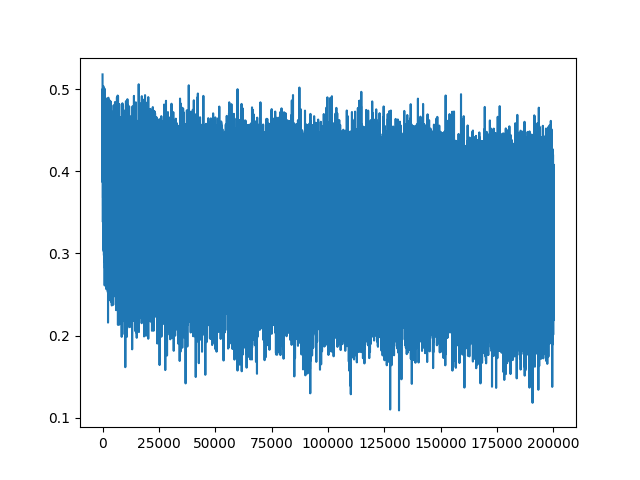

In [25]:
plt.figure(); plt.plot(lossi)

This loss function looks very crazy. We should probably fix this. And that's because 32 batch elements are too few. And so you can get very lucky or unlucky in any one of these batches, and it creates a very thick loss function. So we're gonna fix that soon. Now, before we evaluate the trained **nn** by inferring the training and validation loss, we need to remember because of the **batchnorm** layers to set all the layers' `training` flag to `False`:

In [26]:
trigger_eval_mode(layers)
infer_loss(layers, xtrain, ytrain, prefix='train');
infer_loss(layers, xval, yval, prefix='val');

train 2.0583250522613525
val 2.1065292358398438


We still have a ways to go as far as the validation loss is concerned. But if we sample from our model we see that we get relatively name-like results that do no exist in the training set:

In [27]:
sample_from_model(block_size=block_size, layers=layers)

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


But we can improve our loss and improve our results even further. We'll start by fixing that THICC loss plot!

#### **let's fix the loss plot**

One way to turn this thick loss plot into a normal one is to only plot the mean. Remember, `lossi` is a very long list of floats, containing a loss for each training episode:

In [28]:
len(lossi), lossi[:5]

(200000,
 [0.5180676579475403,
  0.5164594054222107,
  0.507362961769104,
  0.507546603679657,
  0.4992470443248749])

Let's segment this very long list into a 2D tensor of rows, with each row containing `1000` loss values:

In [29]:
t_loss = torch.tensor(lossi).view(-1, 1000)
t_loss

tensor([[0.5181, 0.5165, 0.5074,  ..., 0.4204, 0.3860, 0.4014],
        [0.3937, 0.3930, 0.4177,  ..., 0.3788, 0.3896, 0.4054],
        [0.3426, 0.4191, 0.3918,  ..., 0.4447, 0.4419, 0.2821],
        ...,
        [0.3625, 0.3517, 0.3376,  ..., 0.3266, 0.3191, 0.3271],
        [0.2550, 0.3659, 0.2968,  ..., 0.2744, 0.3853, 0.3300],
        [0.3041, 0.2740, 0.3213,  ..., 0.3081, 0.4082, 0.3207]])

Now, if take the mean of each row, we end up with a list of loss averages:

In [30]:
mean_t_loss = t_loss.mean(1)
mean_t_loss

tensor([0.4059, 0.3791, 0.3698, 0.3681, 0.3657, 0.3639, 0.3624, 0.3593, 0.3557,
        0.3561, 0.3516, 0.3515, 0.3504, 0.3501, 0.3491, 0.3477, 0.3498, 0.3474,
        0.3494, 0.3449, 0.3456, 0.3440, 0.3452, 0.3461, 0.3429, 0.3456, 0.3458,
        0.3438, 0.3408, 0.3437, 0.3435, 0.3407, 0.3424, 0.3412, 0.3415, 0.3404,
        0.3419, 0.3391, 0.3414, 0.3396, 0.3392, 0.3408, 0.3394, 0.3416, 0.3389,
        0.3390, 0.3376, 0.3407, 0.3364, 0.3376, 0.3393, 0.3362, 0.3371, 0.3349,
        0.3393, 0.3369, 0.3363, 0.3349, 0.3338, 0.3386, 0.3366, 0.3388, 0.3370,
        0.3379, 0.3349, 0.3378, 0.3325, 0.3358, 0.3353, 0.3390, 0.3369, 0.3366,
        0.3354, 0.3350, 0.3375, 0.3347, 0.3352, 0.3352, 0.3318, 0.3359, 0.3348,
        0.3338, 0.3350, 0.3367, 0.3331, 0.3333, 0.3346, 0.3356, 0.3339, 0.3339,
        0.3332, 0.3331, 0.3352, 0.3356, 0.3350, 0.3335, 0.3330, 0.3299, 0.3344,
        0.3350, 0.3318, 0.3295, 0.3328, 0.3336, 0.3345, 0.3341, 0.3319, 0.3342,
        0.3329, 0.3299, 0.3346, 0.3312, 

If we plot this tensor list of mean losses, we should get a nicer loss plot:

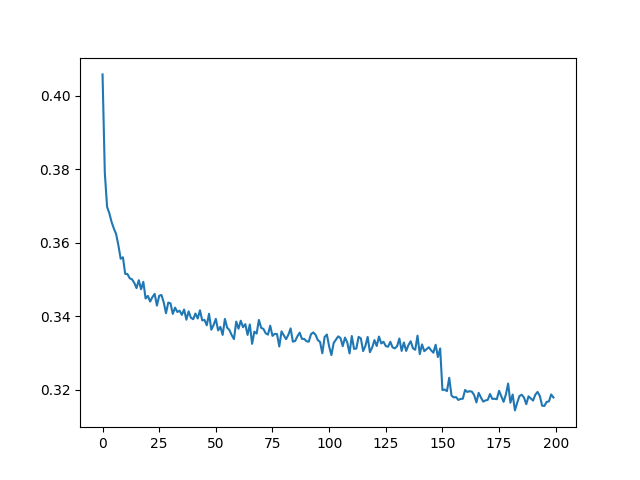

In [31]:
plt.figure(); plt.plot(mean_t_loss)

Now, the progress we make during training is much more clearly visible! Also, notice the learning rate decay, where the loss drops to a lower minimum. This is the loss plot we are going to be using going forward.

#### **pytorchifying our code: layers, containers, torch.nn**

Now it's time to simplify our forward function a little bit. Notice how the embeddings and flattening operations are calculated outside of the layers:

```python
def forward(layers, xb, yb):
    emb = C[xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        ...
```

To start tidying things up, let's mirror [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) and [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) with our own incredibly simplified equivalent modules:

In [32]:
class Embedding:
    def __init__(self, n_embd, embd_dim):
        self.weight = torch.randn((n_embd, embd_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]

In [33]:
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
  
    def parameters(self):
        return []

These will simply be responsible for indexing and flattening. We can now simplify our forward pass by including the embedding and flattening operations as modules in the definition of the layers:

In [34]:
def define_nn(block_size, n_embd, n_hidden):
    n_inputs = n_embd * block_size
    n_outputs = vocab_size
    layers = [
        Embedding(vocab_size, n_embd),
        Flatten(),
        Linear(n_inputs, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_outputs)
    ]
    # parameter init
    with torch.no_grad():
        layers[-1].weight *= 0.1  # last layer make less confident
    parameters = [p for l in layers for p in l.parameters()]
    print(sum(p.nelement() for p in parameters))  # number of parameters in total
    for p in parameters:
        p.requires_grad = True
    return layers, parameters

In [35]:
def forward(layers, xb, yb):
    x = xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb) # loss function
    return loss

Awesome. Now we can even further simplify our forward pass by replacing the layers iteration by replacing the list that contains our layers with our simplified implementation of the [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) container: this object contains layers and the functionality to iteratively pass data through them. Meaning that we now define a bunch of layers as a `Sequential` object (i.e. a model) through which we can pass input data (e.g. `x`), without the need to explicitly loop.

In [36]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

Let's now further simplify our functions by replacing the `layers` list with `model`, a `Sequential` object:

In [37]:
def define_nn(block_size, n_embd, n_hidden):
    n_inputs = n_embd * block_size
    n_outputs = vocab_size
    model = Sequential([
        Embedding(vocab_size, n_embd),
        Flatten(),
        Linear(n_inputs, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_outputs)
    ])
    # parameter init
    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # last layer make less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))  # number of parameters in total
    for p in parameters:
        p.requires_grad = True
    return model, parameters

In [38]:
def forward(model, xb, yb):
    logits = model(xb)
    loss = F.cross_entropy(logits, yb) # loss function
    return loss

In [39]:
def train(x, y, model, parameters, initial_lr=0.1, maxsteps=200000, batchsize=32, break_at_step=None):
    lossi = []
    for i in range(maxsteps):
        # minibatch construct
        bix = torch.randint(0, x.shape[0], (batchsize,))
        xb, yb = x[bix], y[bix]
        loss = forward(model, xb, yb)
        backward(parameters, loss)
        lr = initial_lr if i < 150000 else initial_lr / 10
        update(parameters, lr=lr)
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{maxsteps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        if break_at_step is not None and i >= break_at_step:
            break
    return lossi

In [40]:
def trigger_eval_mode(model):
    for l in model.layers:
        l.training = False

In [41]:
@torch.no_grad()
def infer_loss(model, x, y, prefix=''):
    loss = forward(model, x, y)
    print(f'{prefix} {loss}')
    return loss

In [42]:
def sample_from_model(block_size, model):
    for _ in range(20):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        print(''.join(itoc[i] for i in out)) # decode and print the generated word

Let's verify that our new definitions work by re-training our **nn**:

In [43]:
model, parameters = define_nn(block_size, n_embd, n_hidden)
lossi = train(xtrain, ytrain, model, parameters)

12097
      0/ 200000: 3.3055
  10000/ 200000: 2.1954
  20000/ 200000: 2.2630
  30000/ 200000: 2.0618
  40000/ 200000: 2.0468
  50000/ 200000: 2.1775
  60000/ 200000: 2.1750
  70000/ 200000: 1.9390
  80000/ 200000: 2.1816
  90000/ 200000: 2.0516
 100000/ 200000: 2.0578
 110000/ 200000: 2.2706
 120000/ 200000: 2.3313
 130000/ 200000: 2.1557
 140000/ 200000: 2.0983
 150000/ 200000: 1.9418
 160000/ 200000: 1.9421
 170000/ 200000: 2.1256
 180000/ 200000: 2.2467
 190000/ 200000: 1.6821


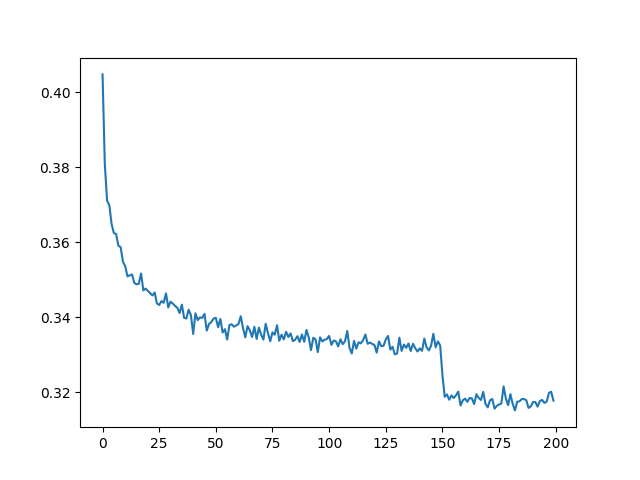

In [44]:
plt.figure(); plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [45]:
trigger_eval_mode(model)
infer_loss(model, xtrain, ytrain, prefix='train');
infer_loss(model, xval, yval, prefix='val');

train 2.0581207275390625
val 2.105104684829712


In [46]:
sample_from_model(block_size, model)

masea.
iman.
ryy.
ayee.
havajine.
miliakendalikain.
amagntanton.
aviona.
jah.
wiseegh.
avon.
man.
tovi.
sullessa.
marcuz.
jazia.
abellabell.
athin.
ahkiara.
krister.


Cool. Now it's time to decrease the loss even further by scaling up our model to make it bigger and deeper!

#### **overview: **WaveNet****

Now, currently, we are using this architecture here:

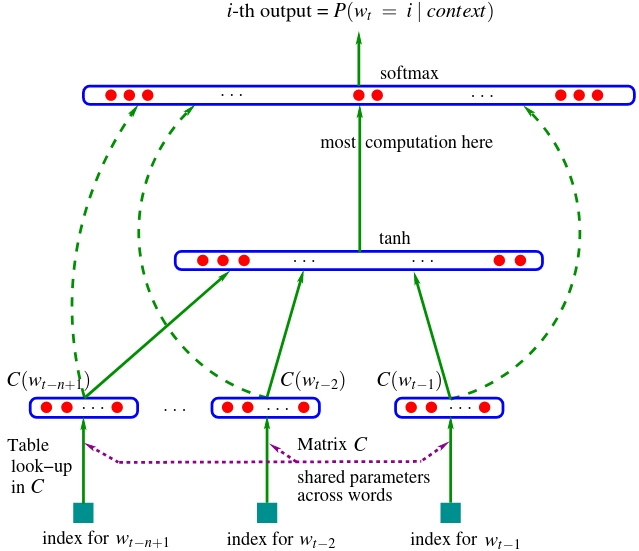

In [47]:
from IPython.display import Image, display
display(Image(filename='bengio2003nn.jpeg'))

where we are taking in some number of characters, going into a single hidden layer, and then going to the prediction of the next character. The problem here is we don't have a naive way of making this bigger in a productive way. We could, of course, use our neural network. We could use our layers, sort of building blocks and materials to introduce additional layers here and make the network deeper. But it is still the case that we are crushing all of the characters into a single layer all the way at the beginning. And even if we make this a bigger layer and add neurons, it's still kind of like silly to squash all that information so fast in a single step. So what we'd like to do instead is we'd like our network to look a lot more like this in the **WaveNet** case:

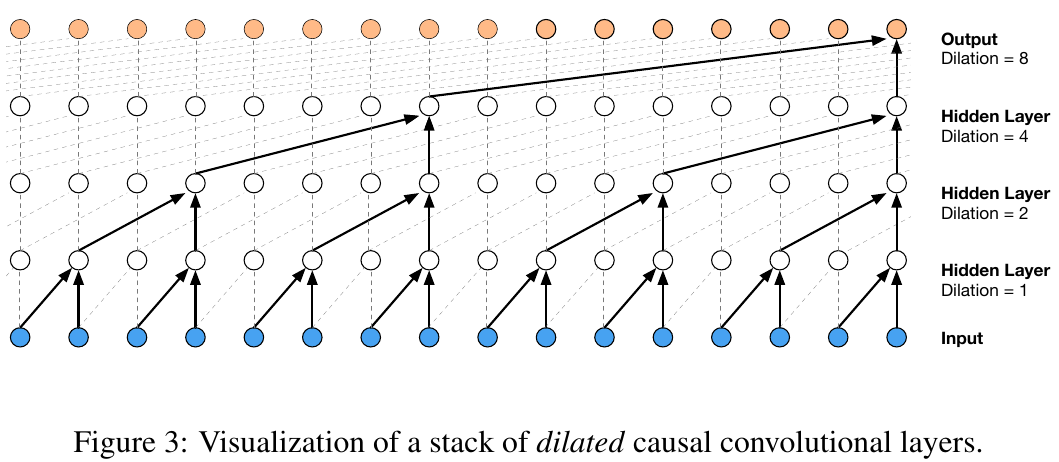

In [48]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig3.png'))

So you see in the **WaveNet**, when we are trying to make the prediction for the next character in a sequence, it is a function of the previous characters that feed in, but not all of these different characters are not just crushed to a single layer and then you have a sandwich. They are crushed slowly. So in particular, we take two characters and we fuse them into sort of like a bigram representation. And we do that for all these characters consecutively. And then we take the bigrams and we fuse those into four character level chunks. And then we fuse that again. And so we do that in this tree-like hierarchical manner. So we fuse the information from the previous context slowly into the network as it gets deeper. And so this is the kind of architecture that we want to implement. Now in the **WaveNet**'s case, this is a visualization of a stack of *dilated* causal convolution layers. And this makes it sound very scary, but actually the idea is very simple. And the fact that it's a *dilated* causal convolution layer is really just an implementation detail to make everything fast. We're going to see that later. But for now, let's just keep going. We're going to keep the basic idea of it, which is this progressive fusion. So we want to make the network deeper, and at each level, we want to fuse only two consecutive elements. Two characters, then two bigrams, then two fourgrams, and so on. So let's implement this.

#### **dataset bump the context size to 8**

Okay, so first up, let me scroll to where we built the dataset, and let's change the block size from `3` to `8`. So we're going to be taking eight characters of context to predict the ninth character:

In [49]:
block_size = 8
(xtrain, ytrain), (xval, yval), (xtest, ytest) = build_all_datasets(block_size)

torch.Size([182473, 8]) torch.Size([182473])
torch.Size([22827, 8]) torch.Size([22827])
torch.Size([22846, 8]) torch.Size([22846])


So the dataset now looks like this:

In [50]:
print_next_character(xtrain[:20], ytrain[:20])

........ --> c
.......c --> a
......ca --> t
.....cat --> h
....cath --> y
...cathy --> .
........ --> k
.......k --> e
......ke --> n
.....ken --> a
....kena --> d
...kenad --> i
..kenadi --> .
........ --> a
.......a --> m
......am --> i
.....ami --> .
........ --> l
.......l --> a
......la --> r


#### **re-running baseline code on block_size 8**

These `8` characters are going to be processed in the above tree-like structure. Let's find out how to implement this hierarchical scheme! But before doing that let's train our simple fully-connected **nn** with this new dataset and see how well it performs:

In [51]:
model, parameters = define_nn(block_size, n_embd, n_hidden)
lossi = train(xtrain, ytrain, model, parameters)

22097
      0/ 200000: 3.3024
  10000/ 200000: 2.1462
  20000/ 200000: 2.2304
  30000/ 200000: 2.1978
  40000/ 200000: 2.3442
  50000/ 200000: 2.1926
  60000/ 200000: 2.4338
  70000/ 200000: 2.0021
  80000/ 200000: 2.0781
  90000/ 200000: 1.7328
 100000/ 200000: 2.2064
 110000/ 200000: 1.9591
 120000/ 200000: 1.9200
 130000/ 200000: 1.7876
 140000/ 200000: 2.0151
 150000/ 200000: 1.9124
 160000/ 200000: 1.9154
 170000/ 200000: 2.4858
 180000/ 200000: 2.0312
 190000/ 200000: 1.7150


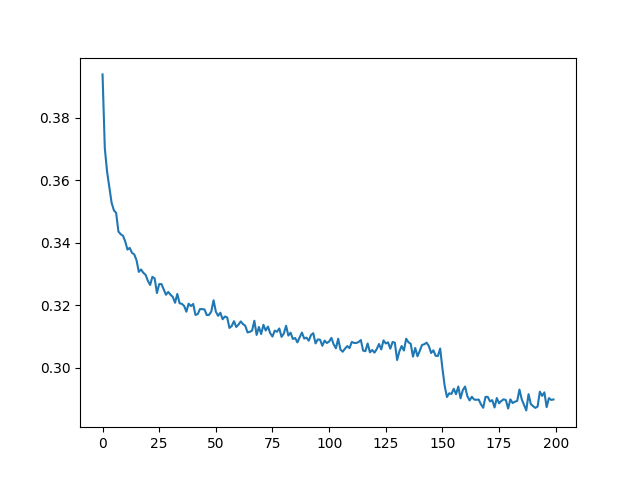

In [52]:
plt.figure(); plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [53]:
trigger_eval_mode(model)
infer_loss(model, xtrain, ytrain, prefix='train');
infer_loss(model, xval, yval, prefix='val');

train 1.9159809350967407
val 2.0343399047851562


Interesting! The loss has improved compared to the `block_size = 3` case. Let's log our losses so far:

##### **performance log**

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.915, val 2.034

Also, if we sample from the model, we can see the names improving qualitatively as well:

In [54]:
sample_from_model(block_size, model)

kobi.
pran.
marlecm.
lunghan.
camillo.
shatar.
elizee.
lumarius.
deris.
brook.
madaniy.
yarel.
milaal.
aylen.
nikora.
niani.
sahanlaa.
elaya.
malixa.
dalioluw.


So we could, of course, spend a lot of time here tuning things and scaling up our network further. But let's continue and let's implement the hierarchical model and treat this as just a rough baseline performance. There's a lot of optimization left on the table in terms of some of the hyperparameters that you're hopefully getting a sense of now.

#### **implementing WaveNet**

Let's now create a bit of a scratch space for us to just look at the forward pass of the  **nn** and inspect the shape of the shape of the tensors along the way, as the **nn** "forwards":

In [55]:
# let's look at a batch of just 4 examples
ix = torch.randint(0, xtrain.shape[0], (4,))
xb, yb = xtrain[ix], ytrain[ix]
logits = model(xb)
print(xb.shape)
xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  0, 18,  5],
        [ 0,  0,  0, 11,  1, 12,  9, 14],
        [ 0,  0,  0,  0,  0, 11,  9, 18]])

So here we are just temporarily for debugging, creating a batch of just, say, `4` examples. So `4` random integers. Then we are plucking out those rows from our training set. And then we are passing into the model the input `xb`. Now the shape of `xb` here, because we have only `4` examples. And this `8` is now the current block size. So inspecting `xb`, we just see that we have four examples. Each one of them is a row of `xb`. And we have `8`  characters here. And each integer tensor row of `xb` just contains the identities of those characters. So the first layer of our **nn** is the embedding layer. So passing `xb`, this integer tensor, through the `Embedding` layer creates an output:

In [56]:
model.layers[0].out.shape  # output of Embedding layer

torch.Size([4, 8, 10])

So our embedding table `C` has, for each character, a `10`-dimensional vector (`n_embd=10`) that we are trying to learn. What the layer does here is it plucks out the embedding vector for each one of these integers (of `xb` and organizes it all in a `4x8x10` tensor. So all of these integers are translated into `10`-dimensional vectors inside this three-dimensional tensor now.

In [57]:
model.layers[1].out.shape  # output of Flatten layer

torch.Size([4, 80])

Now passing that through the `Flatten` layer, as you recall, what this does is it views this tensor as just a `4x80` tensor. And what that effectively does is that all these `10`-dimensional embeddings for all these `8` characters just end up being stretched out into a long row. And that looks kind of like a concatenation operation, basically. So by viewing the tensor differently, we now have a `4x80`. And inside this `80`, it's all the `10`-dimensional vectors just concatenated next to each other.

In [58]:
model.layers[2].out.shape  # output of Linear layer

torch.Size([4, 200])

And the linear layer, of course, takes `80` and creates `200` channels just via matrix multiplication. So far, so good. Now let's see something surprising. Let's look at the insides of the `Linear` layer and remind ourselves how it works:

```python
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
...
```

The `Linear` layer here in a forward pass takes the input `x`, multiplies it with a weight, and then optionally adds bias. And the weight here is two-dimensional, as defined here, and the bias is one-dimensional. So effectively, in terms of the shapes involved, what's happening inside this `Linear` layer looks like this right now. And we're using random numbers here, but just to illustrate the shapes and what happens:

In [59]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

Basically, a `4x80` comes into the `Linear` layer, gets multiplied by a `80x200` weight matrix inside, and then there's a plus `200` bias. And the shape of the whole thing that comes out of the `Linear` layer is `4x200`, as we see here. Now notice here, by the way, that the matrix multiplication here will create a `4x200` tensor, and then when adding `200` there's a broadcasting happening here, but since `4x200` broadcasts with `200`,  everything works here. So now the surprising thing is how this works. Specifically, something you may not expect is that this input here that the input tensor being matrix-multiplied doesn't actually have to be two-dimensional. This matrix multiply operator in `pytorch` is quite powerful, and in fact, you can actually pass in higher dimensional arrays or tensors, and everything works fine. So for example, `torch.randn(4, 80)` could instead be `torch.randn(4, 5, 80)` (`4x5x80`) and the result in that case would become `4x5x200`. You can add as many dimensions as you like to the left of the last dimension of the input tensor (here, dimension `80`). And so effectively, what's happening is that the matrix multiplication only works on a
matrix multiplication on the last dimension, and the dimensions before it in the input tensor are left unchanged. So basically, these dimensions to the left of the last dimension are all treated as just a batch dimension. So we can have multiple batch dimensions (e.g. `torch.randn(4, 5, 6, 7, 80)`), and then in parallel over all those dimensions, we are doing the matrix multiplication only on the last dimension. So this is quite convenient because we can use that in our **nn** now. Because remember that. We have these `8` characters coming in, e.g.

```python
# 1 2 3 4 5 6 7 8
```

And we don't want to now flatten all of it out into a large `8`-dimensional vector, because we don't want to matrix multiply `80` into a weight matrix multiply immediately. Instead, we want to group these like this:

```python
# (1 2) (3 4) (5 6) (7 8)
```

So every consecutive two elements, should be now basically flattened and multiplied by a weight matrix. But the idea is that all of these four groups here, we'd like to process in parallel. So it's kind of like a extra batch dimension that we can introduce. And then we can, in parallel, basically process all of these bigram groups in the four extra batch dimension of an individual example, and also over the actual batch dimension of the four
examples. So let's see what this is all about and how that works. Right now, we take a `4x80` and multiply it by `80x200` in the linear layer. Effectively, what we want is instead of `8` characters (`80` embedding numbers) coming in, we only want `2` characters (`20` embedding numbers) to come in. Therefore, if we want that, we can't have a `4x80` feeding into the `Linear` layer, but instead `4` groups of `2` characters to be feeding in, like this:

In [60]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

Therefore, what we would want to do now is change the `Flatten` layer so that it doesn't output a `4x80` but a `4x4x20` where basically in each row tensor of `xb`:

In [61]:
xb

tensor([[ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  0, 18,  5],
        [ 0,  0,  0, 11,  1, 12,  9, 14],
        [ 0,  0,  0,  0,  0, 11,  9, 18]])

every two consecutive characters (e.g. `(0, 0)`, `(10, 21)`, `(12,  9)`, `(5, 1)`) are packed in on the very last dimension (i.e. `20`). So that the first dimension (i.e. `4`) is the first batch dimension and the second dimension (i.e. `4`) is the second batch dimension. And this is where we want to get to:

In [62]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

So we have to change our `Flatten` layer (so that it doesn't fully flatten out the examples, but creates a `4x4x20` instead of a `4x80`) and our `Linear` layer (to expect `20` instead of `80`). So let's see how this could be implemented. Basically right now we have an input that is a `4x8x10` that feeds into the `Flatten` layer, and currently the `Flatten` layer just stretches it out:

```python
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
...
```

through the `view` operation. Effectively what it does now is:

In [63]:
e = torch.randn(4, 8, 10)  # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
e.view(4, -1).shape  # yields 4x80

torch.Size([4, 80])

But we want to just view the same tensor as a `4x4x20` instead, so:

In [64]:
e.view(4, 4, -1).shape  # yields 4x4x20: this is what we want!

torch.Size([4, 4, 20])

Easy, right? Let's now rewrite `Flatten`, but since ours will now start to depart from [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten), we'll rename it to `FlattenConsecutive` just to make sure that our APIs somewhat similar but not the same:

In [65]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        b, t, c = x.shape
        x = x.view(b, t // self.n, c * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

So `FlattenConsecutive` receives takes in and flattens only some `n` consecutive elements and puts them into the last dimension. In `__call__` we parse the three dimensions of the input `x` as `b`, `c`, `t` (e.g. `4`, `8`, `10`) and then we view `x` as a `b`, `t // n`, `c * n` tensor (e.g. `4`, `8 // 2`, `10 * 2`, aka: `4`, `4`, `20`). Last but not least we check whether the middle dimension of `x` (`x.shape[1]`) is `1` and if so, then we simply squeeze out that dimension (e.g. `4x1x10` would become `4x10`). Let's now replace `Flatten` with our new `FlattenConsecutive` while maintaining the same functionality:

In [66]:
def define_nn(block_size, n_embd, n_hidden):
    n_inputs = n_embd * block_size
    n_outputs = vocab_size
    model = Sequential([
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(block_size),
        Linear(n_inputs, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_outputs)
    ])
    # parameter init
    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # last layer make less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))  # number of parameters in total
    for p in parameters:
        p.requires_grad = True
    return model, parameters

Now, let's define the model and verify that the shapes of the layer outputs are the same after feeding one batch of data into it:

In [67]:
model, _ = define_nn(block_size, n_embd, n_hidden)
print(xb.shape)
model(xb)
for l in model.layers:
    print(l.__class__.__name__, ':', tuple(l.out.shape))

22097
torch.Size([4, 8])
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


So, we see the shapes as we expect them after every single layer in its output. Now, let's try to restructure it and do it hierarchically:

In [68]:
def define_nn(block_size, n_embd, n_hidden):
    n_consec = 2
    n_inputs = n_embd * n_consec
    n_outputs = vocab_size
    model = Sequential([
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(n_consec), Linear(n_inputs, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_outputs)
    ])
    # parameter init
    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # last layer make less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))  # number of parameters in total
    for p in parameters:
        p.requires_grad = True
    return model, parameters

Now, let's inspect the numbers in between after a forward pass on a new **nn**:

In [69]:
model, _ = define_nn(block_size, n_embd, n_hidden)
print(xb.shape)
model(xb)
for l in model.layers:
    print(l.__class__.__name__, ':', tuple(l.out.shape))

170897
torch.Size([4, 8])
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


So `4x8x20` was flattened consecutively into `4x4x20`. Through the `Linear` layer, this was projected into `4x4x200`. And then `BatchNorm1d` just works out of the box and so does `Tanh`, which is element-wise. Then we crushed it again. So we flattened consecutively once more and ended up with a `4x2x400` now. Then `Linear` brought it back down to `4x2x200`, `BatchNorm1d` and `Tanh` didn't change the shape and for the last flattening,
it squeezed out that dimension of 1, we end up with `4x400`. And then `Linear`, `BatchNorm1d`, `Tanh` and the last `Linear` yield our logits that end up in the same shape as they were before. But now we actually have a nice three-layer **nn** that basically corresponds to this **WaveNet** network now:

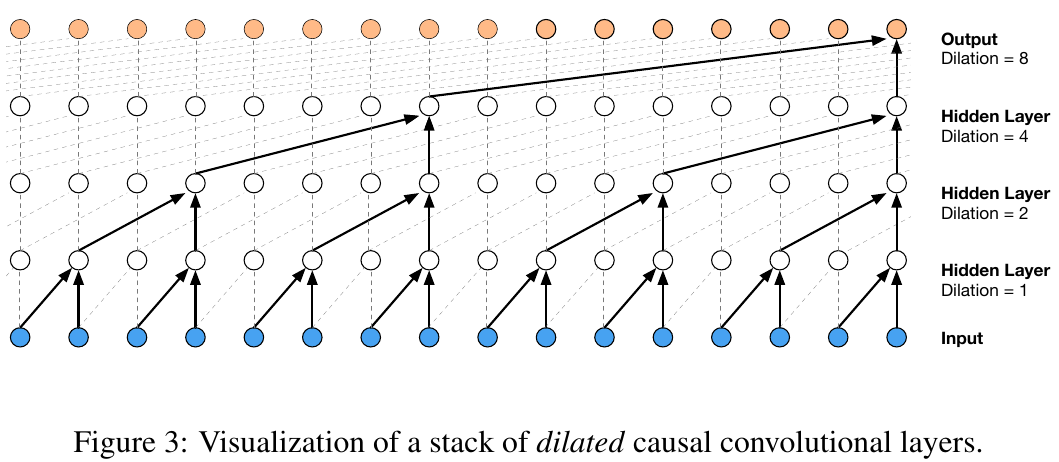

In [70]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig3.png'))

with the only difference that we are using a blocksize of `8` instead of `16`, as depicted above. Now with a new architecture, we just have to kind of figure out some good channel numbers (numbers of hidden units) to use here. If we decrease the number to:

In [71]:
n_hidden = 68

Then the total number of parameters comes out to `22000`: exactly the same that we had before (when `n_hidden=200`). So we have the same amount of capacity with this **nn** in terms of the number of parameters. But the question is whether we are utilizing those parameters in a more efficient architecture.

#### **training the WaveNet: first pass**

Let's train this **WaveNet** and see the results:

In [72]:
model, parameters = define_nn(block_size, n_embd, n_hidden)
lossi = train(xtrain, ytrain, model, parameters)

22397
      0/ 200000: 3.2978
  10000/ 200000: 2.1271
  20000/ 200000: 2.0807
  30000/ 200000: 1.6842
  40000/ 200000: 2.0252
  50000/ 200000: 2.3853
  60000/ 200000: 2.4678
  70000/ 200000: 1.7907
  80000/ 200000: 2.2092
  90000/ 200000: 2.3790
 100000/ 200000: 1.7643
 110000/ 200000: 1.6553
 120000/ 200000: 1.9414
 130000/ 200000: 1.9827
 140000/ 200000: 1.7703
 150000/ 200000: 1.8300
 160000/ 200000: 1.6640
 170000/ 200000: 1.9619
 180000/ 200000: 1.7971
 190000/ 200000: 1.9981


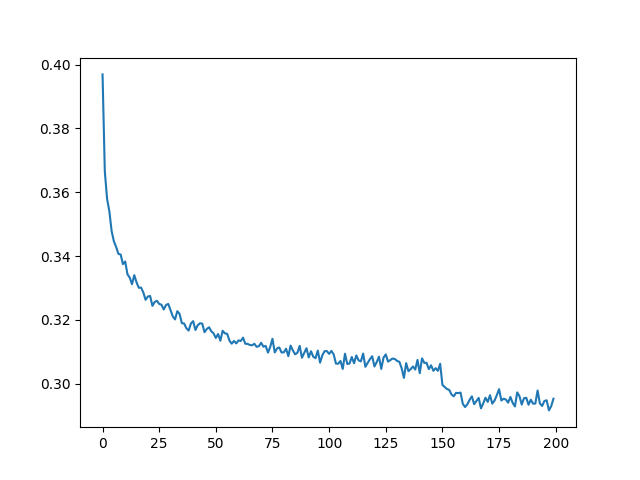

In [73]:
plt.figure(); plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [74]:
trigger_eval_mode(model)
infer_loss(model, xtrain, ytrain, prefix='train');
infer_loss(model, xval, yval, prefix='val');

train 1.9376758337020874
val 2.026397943496704


##### **performance log**

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.915, val 2.034
- flat -> hierachical (22K params): train 1.937, val 2.026

As you can see, changing from the flat to hierachical model (while keeping the same number of parameters) is not giving us any noticeable significant benefit in terms of loss.  That said, there are two things to point out. Number one, we didn't really "torture" the architecture here very much.
And there's a bunch of hyperparameter search that we could do in terms of how we allocate our budget of parameters to what layers. Number two, we still may have a bug inside the `BatchNorm1d` layer. So let's take a look at that because it runs but doesn't do the right thing.

#### **fixing BatchNorm1d bug**

If train for just one step and we print the layer output shapes:

In [75]:
_ = train(xtrain, ytrain, model, parameters, break_at_step=1);
model(xb)
for l in model.layers:
    print(l.__class__.__name__, ':', tuple(l.out.shape))

      0/ 200000: 2.0969
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


currently it looks like the BatchNorm is receiving an input that is `32x4x68`, right?
Let's take a look at the implementation of BatchNorm:

```python
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]
```
It assumed, in the way we wrote it and at the time, that the input `x` is two-dimensional. So it was N by D, where N was the batch size. So that's why we only reduced the mean and the variance over the zeroth dimension. But now `x` will basically become three-dimensional. So what's happening inside the **batchnorm** layer right now? And how come it's working at all and not giving any errors? The reason for that is basically because everything broadcasts properly, but the **batchnorm** is not doing what we want it to do. So in particular, let's basically think through what's happening inside the **batchnorm**. Let's look at what's happening here in a simplified example:

In [76]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)  # 1, 4, 68
evar = e.var(0, keepdim=True)  # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

So we're receiving an input of `32x4x68`. And then we are doing here `x.mean()` but we have `e` instead of `x`. But we're doing the mean over zero and that's actually giving us `1x4x68`. So we're doing the mean only over the very first dimension. And it's giving us a mean and a variance that still maintain the middle dimension in between (i.e. `4`). So these means are only taken over `32` numbers in the first dimension. And then when we perform the `ehat` assignment, everything broadcasts correctly still. But basically what ends up happening is when we also look at the running mean:

In [77]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

the shape of this running mean now is `1x4x68`. Instead of it being just size of dimension, because we have `68` channels, we expect to have `68` means and variances that we're maintaining. But actually we have an array of `4` by `68`. And so basically what this is telling us is this **batchnorm** is currently working in parallel over `4` times `68` instead of just `68` channels. So basically we are maintaining this. We are maintaining statistics for every one of these four positions individually and independently. And instead what we want to do is we want to treat this middle `4` dimension as a batch dimension, just like the 0th dimension. So as far as the **batchnorm** is concerned, it doesn't want to average...
We don't want to average over `32` numbers. But instead, we want to now average over `32x4` numbers for every single one of these `68` channels. Since 
[`torch.mean`](https://pytorch.org/docs/stable/generated/torch.mean.html) allows us to reduce over multiple (and not just one) dimensions at the same time, we'll do just that and reduce over both the `0`th and `1`st dimensions:

In [78]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True)  # 1, 1, 68
evar = e.var((0, 1), keepdim=True)  # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

Although the final shape of `ehat` remains the same, we see now that:

In [79]:
emean.shape, evar.shape

(torch.Size([1, 1, 68]), torch.Size([1, 1, 68]))

instead of `1, 4, 68`, since we reduced over both of the batch dimensions, yields only `68` numbers for each tensor, with a bunch of spurious leftover `1` dimensions remaining. Therefore, this is what should be happening with our `running_mean` and `running_var` tensors inside our `BatchNorm1d` implementation. So the change is pretty straightforward:

In [80]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

Basically, now in `__call__` we are checking the dimensionality of `x` and based on it we are determining the `dim` parameters to be passed to the `mean` and `var` functions. Now, to point out one more thing. We're actually departing from the API of PyTorch here a little bit, because when you go read the documentation of [`torch.nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), it says:

> - Input: $(N,C)$ or $(N,C,L)$, where $N$ is the batch size, $C$ is the number of features or channels, and $L$ is the sequence length

see that the input to this layer can either be $N$ (batch size) by $C$ (number of features or channels) or it actually does accept three-dimensional inputs, but it expects it to be $N$ by $C$ by $L$ (sequence legth). So this is a problem because you see how c is nested here in the middle. And so when it gets three-dimensional inputs, this **batchnorm** layer will reduce over `0` and `2` instead of `0` and `1`. So basically, [`torch.nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) layer assumes that $C$ will always be the first dimension, whereas we assume here that $C$ is the last dimension, and there are some number of batch dimensions beforehand. And so, it expects $(N,C)$ or $(N,C,L)$, whereas we expect $(N,C)$ or $(N,L,C)$. So just a small deviation from the `pytorch` API. Now, after updating our `BatchNorm1d`, if we redefine our **nn** and run for one step:

In [81]:
model, parameters = define_nn(block_size, n_embd, n_hidden)
_ = train(xtrain, ytrain, model, parameters, break_at_step=1);
model(xb)
for l in model.layers:
    print(l.__class__.__name__, ':', tuple(l.out.shape))

22397
      0/ 200000: 3.2907
Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


the shapes are of course the same as before, but now if we inspect the shape of the `running_mean` inside the **batchnorm** layer:

In [82]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

So correctly now we are only maintaining `68` means, for every one of our channels, and we are treating the `0`th and the `1`st dimension as batch dimensions, which is exactly what we want!

#### **re-training WaveNet after bug fix**

So let's retrain the **nn** now, after the bug fix:

In [83]:
model, parameters = define_nn(block_size, n_embd, n_hidden)
lossi = train(xtrain, ytrain, model, parameters)

22397
      0/ 200000: 3.3054
  10000/ 200000: 2.2512
  20000/ 200000: 2.3514
  30000/ 200000: 2.5115
  40000/ 200000: 1.6012
  50000/ 200000: 2.1728
  60000/ 200000: 1.8859
  70000/ 200000: 2.1417
  80000/ 200000: 2.0348
  90000/ 200000: 1.7458
 100000/ 200000: 1.7257
 110000/ 200000: 1.9065
 120000/ 200000: 2.0347
 130000/ 200000: 2.1898
 140000/ 200000: 2.2163
 150000/ 200000: 1.7984
 160000/ 200000: 1.4846
 170000/ 200000: 1.7952
 180000/ 200000: 2.0809
 190000/ 200000: 2.2824


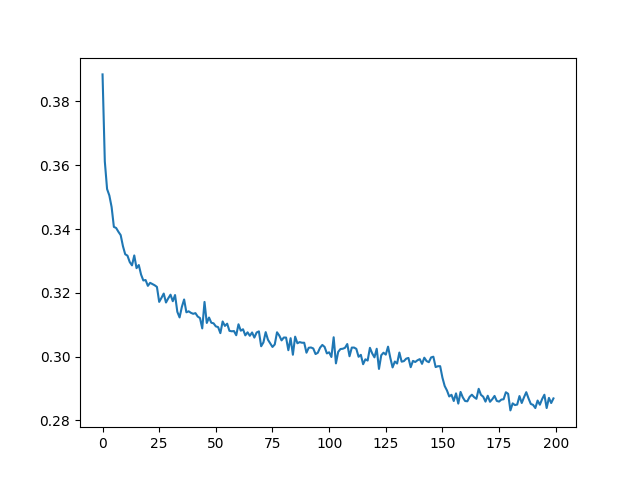

In [84]:
plt.figure(); plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [85]:
trigger_eval_mode(model)
infer_loss(model, xtrain, ytrain, prefix='train');
infer_loss(model, xval, yval, prefix='val');

train 1.911558985710144
val 2.019017219543457


And we can see that we are getting a tiny improvement in our training and validation losses:

##### **performance log**

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.915, val 2.034
- flat -> hierachical (22K params): train 1.937, val 2.026
- fix bug in batchnorm: train 1.911, val 2.019

The reason this improvement is to be expected is that now we have less numbers going into the estimates of the mean and variance which allows everything to be more stable and less wiggly.

#### **scaling up our WaveNet**

And with this more general architecture in place, we are now set up to push the performance further by increasing the size of the network:

In [86]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

And using the exact same architecture, we now have

In [87]:
model, parameters = define_nn(block_size, n_embd, n_hidden)

76579


`76579` parameters and the training takes a lot longer:

In [88]:
lossi = train(xtrain, ytrain, model, parameters)

      0/ 200000: 3.3060
  10000/ 200000: 2.1627
  20000/ 200000: 1.8125
  30000/ 200000: 2.1831
  40000/ 200000: 1.9874
  50000/ 200000: 2.3684
  60000/ 200000: 2.1482
  70000/ 200000: 1.7558
  80000/ 200000: 1.8260
  90000/ 200000: 1.8867
 100000/ 200000: 1.9521
 110000/ 200000: 1.9662
 120000/ 200000: 1.9416
 130000/ 200000: 2.0037
 140000/ 200000: 1.9890
 150000/ 200000: 1.7099
 160000/ 200000: 1.8770
 170000/ 200000: 1.5360
 180000/ 200000: 1.4641
 190000/ 200000: 1.8875


but we do get a nice curve:

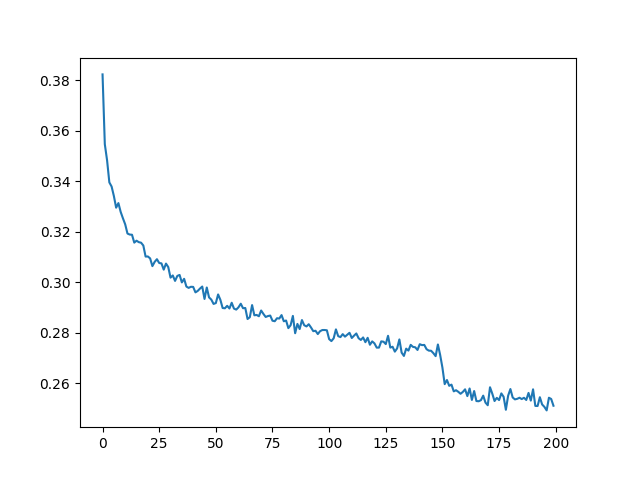

In [89]:
plt.figure(); plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

and we are now getting even better performance:

In [90]:
trigger_eval_mode(model)
infer_loss(model, xtrain, ytrain, prefix='train');
infer_loss(model, xval, yval, prefix='val');

train 1.7666022777557373
val 1.9965752363204956


So, to compare to previous performances:

##### **performance log**

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.915, val 2.034
- flat -> hierachical (22K params): train 1.937, val 2.026
- fix bug in batchnorm: train 1.911, val 2.019
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.768, val 1.990

However because the experiments are starting to take longer to train, we are a little bit in the dark with respect to the correct setting of the hyperparameters here and the learning rates and so on. And so we are missing sort of like an experimental harness on which we could run a number of experiments and really tune this architecture very well.

#### **experimental harness**

So let's conclude now with a few notes. We basically improved our performance noticeably from a val loss of `2.1` to `1.9`. But this shouldn't be the focus as we are kind of in the dark. We have no experimental harness, we are just guessing and checking. And this whole thing is pretty terrible to be honest. We are just looking at the training loss, whereas we should be looking at the training and validation loss together. That said, we did implement the **WaveNet** architecture from the [paper](https://arxiv.org/abs/1609.03499):

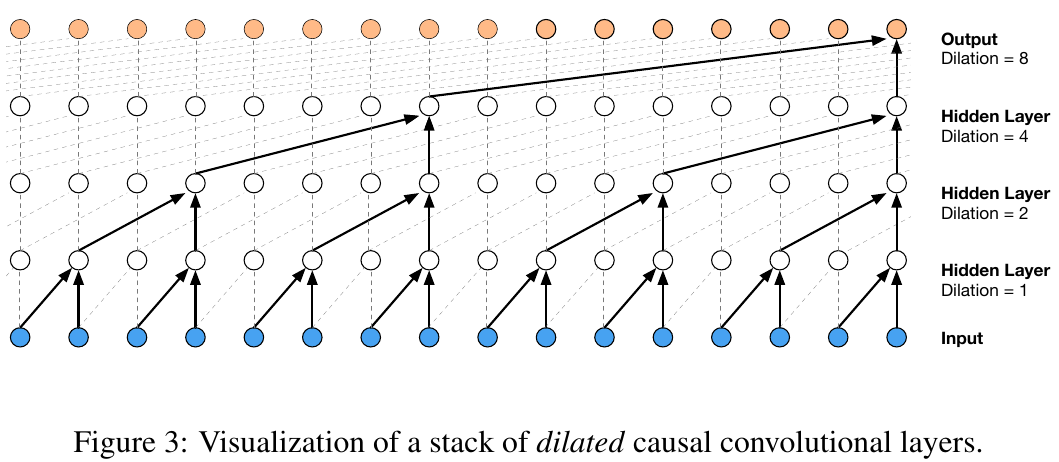

In [119]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig3.png'))

But we did not implement this specific forward pass of it:

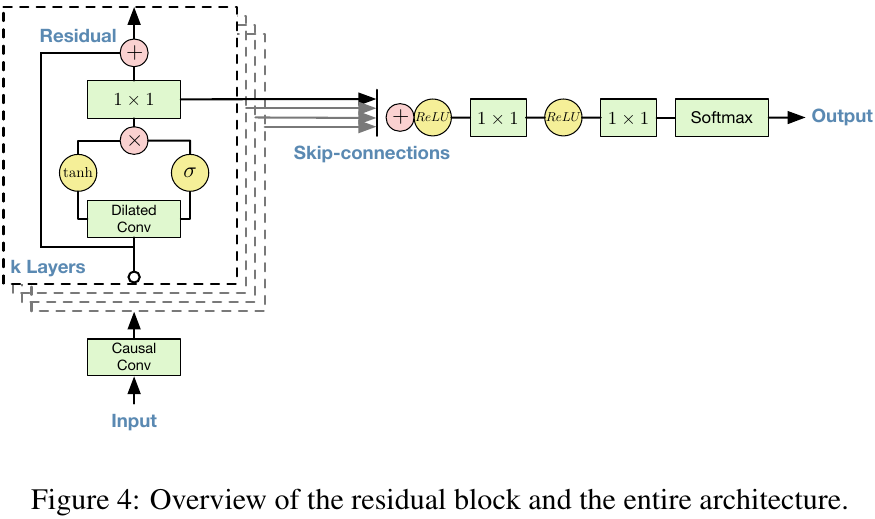

In [92]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig4.png'))

where you have a more complicated kind of gated linear layer with residual connections, skip connections and so on... So we did not implement this, but only the tree-like model.

#### **WaveNet but with dilated causal convolutions**

All things considered, let's briefly go over how what we've done here relates to convolutional neural networks as used in the [WaveNet paper](https://arxiv.org/abs/1609.03499). Basically the use of convolutions is strictly for efficiency. It doesn't actually change the model we've implemented. So, here for example:

In [116]:
print_next_character(xtrain[46:54], ytrain[46:54])

........ --> a
.......a --> n
......an --> a
.....ana --> l
....anal --> i
...anali --> s
..analis --> a
.analisa --> .


For example, we see the name `analisa` from our training set and it has `7` letters, so that is `8` rows which correspond to independent examples of that name. Now, we can forward any one of these rows independently:

In [117]:
# forward a single example
single_example = xtrain[[7]]  # index by [[7]] to get an extra batch dimension
logits = model(single_example)
logits.shape

torch.Size([1, 27])

Now imagine that instead of just a single example, you would like to forward all of the `8` examples that make up the name into the network at the same time:

In [118]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(7):
    logits[i] = model(xtrain[[7 + i]])
logits.shape

torch.Size([8, 27])

Of course, as we've implemented this right now, this is `8` independent calls to our model. But what convolutions allow you to do is they allow you to "slide" this model efficiently over the input sequence. And so this for loop we just wrote out can be done not "outside", through iteration, in Python, but "inside" of kernels in [`CUDA`](https://en.wikipedia.org/wiki/CUDA). And so this for loop gets hidden into the convolution. So basically you can think of the convolution as a for loop applying a little linear filter over space of some input sequence. And in our case the space we're interested in is one dimensional. And we are interested in sliding these filter over the input data. This diagram is quite helpful for understanding actually: 

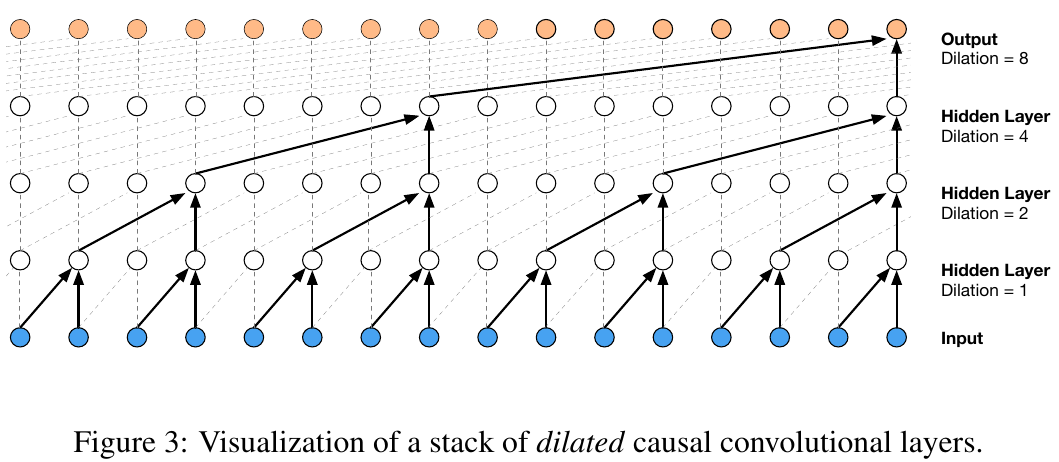

In [120]:
from IPython.display import Image, display
display(Image(filename='wavenet_fig3.png'))

Here, you can see highlighted with black arrows a single tree of the calculation we just described. So depicted here, calculating a single orange node at the **Output** layer corresponds to us in our example forwarding a single example and getting out a single output. But what convolutions allow you to do is it allows you to take this black tree-like structure and kind of like slide it over the **Input** sequence (blue nodes) and calculate all of the orange outputs at the same time. In the above figure, this sliding action is represented by the dashed connections between the nodes. In our example:

In [121]:
print_next_character(xtrain[46:54], ytrain[46:54])

........ --> a
.......a --> n
......an --> a
.....ana --> l
....anal --> i
...anali --> s
..analis --> a
.analisa --> .


this sliding would correspond to calculating all the above `8` outputs at all the positions of the name (like we did in an explicit loop) at the same time. And the reason this is much more efficient is because the for loop is inside the `CUDA` kernels in the sliding. Also notice the node re-use in the diagram were for example in the first **Hidden Layer** each white node is the right child of the white node above it (in the second **Hidden Layer**) but also the left child of another white node (also in the second **Hidden Layer**). Therefore in the first **Hidden Layer**, each node and its value is used twice. Therefore, in our above example snippet, with our naive way we would have to recalculate the value that corresponds to such a node, whereas with such a convolutional **nn** we are allowed to reuse it. So, in the convolutional **nn** you can think of the linear layer as filters. And we take these filters and their linear filters and we slide them over the input sequence and we calculate the first layer, the second layer, the third layer and then the output layer of the sandwich and it is all done very efficiently using these convolutions.

#### **torch.nn**

Another thing to take away from this lecture is having modeled our **nn** lego blocks: the module classes (`Linear`, etc.) after modules from [`torch.nn`](https://pytorch.org/docs/stable/nn.html). So it is now very easy to start using modules directly from PyTorch, from hereon.

#### **the development process of building deep neural nets**

The next thing I hope you got a bit of a sense of is what the development process of building deep neural networks looks like. Which I think was relatively representative to some extent. So number one, we are spending a lot of time in the [documentation page of PyTorch](https://pytorch.org/docs/stable/nn.html). And we're reading through all the layers, looking at documentations, what are the shapes of the inputs, what can they be, what does the layer do, and so on. Unfortunately, however, the PyTorch documentation is not very good, at least not at the time these lectures were implemented. The PyTorch developers spend a ton of time on hardcore engineering of all kinds of distributed primitives, etc. But no one is rigorously maintaining documentation. It will lie to you, it will be wrong, it will be incomplete, it will be unclear. So unfortunately, it is what it is and you just kind of do your best with what they've given us. Number two, the other thing that I hope you got a sense of is there's a ton of trying to make the shapes work. And there's a lot of gymnastics around these multi-dimensional arrays. And are they two-dimensional, three-dimensional, four-dimensional? Do the layers take what shapes? Is it $N$, $C$, $L$ or $N$, $L$, $C$? And you're permuting and viewing, and it just gets pretty messy. And so that brings me to number three. It's often helpful to first prototype these layers and implementations in Jupyter Notebooks and make sure that all the shapes work out and making sure everything is correct. And then once you're satisfied with the functionality in a Jupyter Notebook, you can take that code and copy-paste it into the repository of actual code (e.g. in VS Code). So that's roughly some notes on the development process of working with **nn**s.

#### **going forward**

Lastly, this lecture unlocks a lot of potential further lectures because, number one, we have to convert our **nn** to actually use these dilated causal convolutional layers, so implementing the convnet. Number two, we potentially start to get into what this means, where are residual connections and skip connections and why are they useful. Number three, as we already mentioned, we don't have any experimental harness. So right now we are just guessing and checking everything. This is not representative of typical deep learning workflows. You usually have to set up your evaluation harness. You have lots of arguments that your script can take. You're more comfortably kicking off a lot of experiments. You're looking at a lot of plots of training and validation
losses, and you're looking at what is working and what is not working. And you're working on this like population level, and you're doing all these hyperparameter searches. And so we've done none of that so far. So how to set that up and how to make it good, I think is a whole another topic. And number four, we should probably cover recurring neural networks. RNNs, LSTMs, GRUs, and of course Transformers. So many places to go, and we'll cover that in the future. For all for now. Bye! :)